In [2]:
# Import Libraries
# pip install xarray
import pandas as pd
import numpy as np
import math
import warnings

import time
import hydroeval as he
import json
import matplotlib.pyplot as plt
import xarray as xr
import sys
from datetime import date
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy import stats
import statistics

# **Append Approach**

In [2]:
# Define the function to calculate ARF based on given equations

warnings.filterwarnings("ignore", category=FutureWarning) # "FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. "

def calculate_arf_30m(area, t):
    return 1 - math.exp(-0.82 * t**0.21) + math.exp(-0.82 * t**0.21 - 0.28 * area)

def calculate_arf_1h(area):
    return 143.7 * math.exp(-0.141 * area)

def calculate_arf_2h(area, t):
    return 1 - math.exp(-0.82 * t**0.21) + math.exp(-0.82 * t**0.21 - 0.28 * area)

def calculate_arf_3h(area):
    return 126.85 * math.exp(-0.087 * area)

def calculate_arf_6h(area):
    return 119.41 * math.exp(-0.063 * area)

def calculate_arf_12h(area):
    return 115.12 * math.exp(-0.05 * area)

def calculate_arf_24h(area):
    return 112.19 * math.exp(-0.041 * area)

# Read the CSV file into a pandas DataFrame
def csv_to_dataframe(csv_file):
    df = pd.read_csv(csv_file, low_memory=True)
    
    # print(df)
    
    # Initialize the output DataFrame with the required columns
    df = df[["huc12num", "Area", "STN30m", "STN1h", "STN2h", "STN3h", "STN6h", "STN12h", "STN24h"]]
    

    # Initialize the output DataFrame with the required columns
    output_df = pd.DataFrame(columns=["huc12num", "Area", "ARF30m", "ARF1h", "ARF2h", "ARF3h", "ARF6h", "ARF12h", "ARF24h"])

    # Iterate over unique huc12num and calculate ARF for each
    for huc12num in df["huc12num"].unique():
        area = df.loc[df["huc12num"] == huc12num, "Area"].iloc[0]

        # Calculate ARF values for different time intervals
        arf30m = calculate_arf_30m(area, 0.5)
        arf1h = calculate_arf_1h(area)
        arf2h = calculate_arf_2h(area, 2)
        arf3h = calculate_arf_3h(area)
        arf6h = calculate_arf_6h(area)
        arf12h = calculate_arf_12h(area)
        arf24h = calculate_arf_24h(area)

        # Append the calculated values to the output DataFrame
        output_df = output_df.append({
            "huc12num": huc12num,
            "Area": area,
            "ARF30m": arf30m,
            "ARF1h": arf1h,
            "ARF2h": arf2h,
            "ARF3h": arf3h,
            "ARF6h": arf6h,
            "ARF12h": arf12h,
            "ARF24h": arf24h
        }, ignore_index=True)
        
        
    
    # Perform the additional mathematical analysis for WPMP
    output_df["WPMP30m"] = output_df["ARF30m"] * df["STN30m"]
    output_df["WPMP1h"] = output_df["ARF1h"] * df["STN1h"]
    output_df["WPMP2h"] = output_df["ARF2h"] * df["STN2h"]
    output_df["WPMP3h"] = output_df["ARF3h"] * df["STN3h"]
    output_df["WPMP6h"] = output_df["ARF6h"] * df["STN6h"]
    output_df["WPMP12h"] = output_df["ARF12h"] * df["STN12h"]
    output_df["WPMP24h"] = output_df["ARF24h"] * df["STN24h"]

    return output_df


# Passing Input file
input_csv_file = "StnWshedHUC12.csv"
output_df = csv_to_dataframe(input_csv_file)

# Writing output to csv
output_csv_file = "WPMPFinalAppend.csv"
output_df.to_csv(output_csv_file, index=False)

# **Concat Approach**

In [3]:
# Define the function to calculate ARF based on given equations
def calculate_arf(area, t):
    return 1 - math.exp(-0.82 * t**0.21) + math.exp(-0.82 * t**0.21 - 0.28 * area)

# Read the CSV file into a pandas DataFrame
def csv_to_dataframe(csv_file):
    df = pd.read_csv(csv_file, low_memory=True)

    # Drop duplicates in the "huc12num" column
    df.drop_duplicates(subset=["huc12num"], keep="first", inplace=True)

    # Initialize the output DataFrame with the required columns
    output_df = pd.DataFrame(columns=["huc12num", "Area", "ARF30m", "ARF1h", "ARF2h", "ARF3h", "ARF6h", "ARF12h", "ARF24h"])

    # Iterate over unique huc12num and calculate ARF for each
    for _, row in df.iterrows():
        huc12num = row["huc12num"]
        area = row["Area"]

        # Calculate ARF values for different time intervals
        arf30m = calculate_arf(area, 0.5)
        arf1h = calculate_arf(area, 1)
        arf2h = calculate_arf(area, 2)
        arf3h = calculate_arf(area, 3)
        arf6h = calculate_arf(area, 6)
        arf12h = calculate_arf(area, 12)
        arf24h = calculate_arf(area, 24)

        # Append the calculated values to the output DataFrame
        output_df = pd.concat([output_df, pd.DataFrame([{
            "huc12num": huc12num,
            "Area": area,
            "ARF30m": arf30m,
            "ARF1h": arf1h,
            "ARF2h": arf2h,
            "ARF3h": arf3h,
            "ARF6h": arf6h,
            "ARF12h": arf12h,
            "ARF24h": arf24h
        }])], ignore_index=True)

    # Perform the additional mathematical analysis for WPMP
    output_df["WPMP30m"] = output_df["ARF30m"] * df["STN30m"]
    output_df["WPMP1h"] = output_df["ARF1h"] * df["STN1h"]
    output_df["WPMP2h"] = output_df["ARF2h"] * df["STN2h"]
    output_df["WPMP3h"] = output_df["ARF3h"] * df["STN3h"]
    output_df["WPMP6h"] = output_df["ARF6h"] * df["STN6h"]
    output_df["WPMP12h"] = output_df["ARF12h"] * df["STN12h"]
    output_df["WPMP24h"] = output_df["ARF24h"] * df["STN24h"]

    return output_df

# Example usage:
input_csv_file = "StnWshedHUC12.csv"
output_df = csv_to_dataframe(input_csv_file)

# Save the output DataFrame to a new CSV file
output_csv_file = "WPMPFinalConc.csv"
output_df.to_csv(output_csv_file, index=False)

# **Plot the Results**

## **Best Fit Line**

In [3]:
dfPMP = pd.read_csv('./WshedPMP.csv')
# print(dfPMP.head(5))

In [4]:
## Pass dataset to array

xarPMP = dfPMP.to_xarray()

IM30m = xarPMP['pt30m'];  IM1h = xarPMP['pt1h'];   IM2h = xarPMP['pt2h'];  IM3h = xarPMP['pt3h'];  IM6h = xarPMP['pt6h'];  IM12h = xarPMP['pt12h'];   IM24h = xarPMP['pt24h']; # Precipitation time series approach
# ST30m = xarPMP['wp30m'];  ST1h = xarPMP['wp1h'];   ST2h = xarPMP['wp2h'];  ST3h = xarPMP['wp3h'];  ST6h = xarPMP['wp6h'];  ST12h = xarPMP['wp12h'];   ST24h = xarPMP['wp24h']; # Gridded PMP weighted approach
ST30m = xarPMP['WIPMP30m'];  ST1h = xarPMP['WIPMP1h'];   ST2h = xarPMP['WIPMP2h'];  ST3h = xarPMP['WIPMP3h'];  ST6h = xarPMP['WIPMP6h'];  ST12h = xarPMP['WIPMP12h'];   ST24h = xarPMP['WIPMP24h']; # IMERG ARF
# ST30m = xarPMP['WNPMP30m'];  ST1h = xarPMP['WNPMP1h'];   ST2h = xarPMP['WNPMP2h'];  ST3h = xarPMP['WNPMP3h'];  ST6h = xarPMP['WNPMP6h'];  ST12h = xarPMP['WNPMP12h'];   ST24h = xarPMP['WNPMP24h']; # NOAA ARF
# ST30m = xarPMP['STN30m'];  ST1h = xarPMP['STN1h'];   ST2h = xarPMP['STN2h'];  ST3h = xarPMP['STN3h'];  ST6h = xarPMP['STN6h'];  ST12h = xarPMP['STN12h'];   ST24h = xarPMP['STN24h']; # Station PMP 


# Convert array to a list

ober = [ST30m, ST1h, ST2h, ST3h, ST6h, ST12h, ST24h]  # NOAA Watershed PMP
img = [IM30m, IM1h, IM2h, IM3h, IM6h, IM12h, IM24h]  # IMERG Watershed PMP
tit = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr']

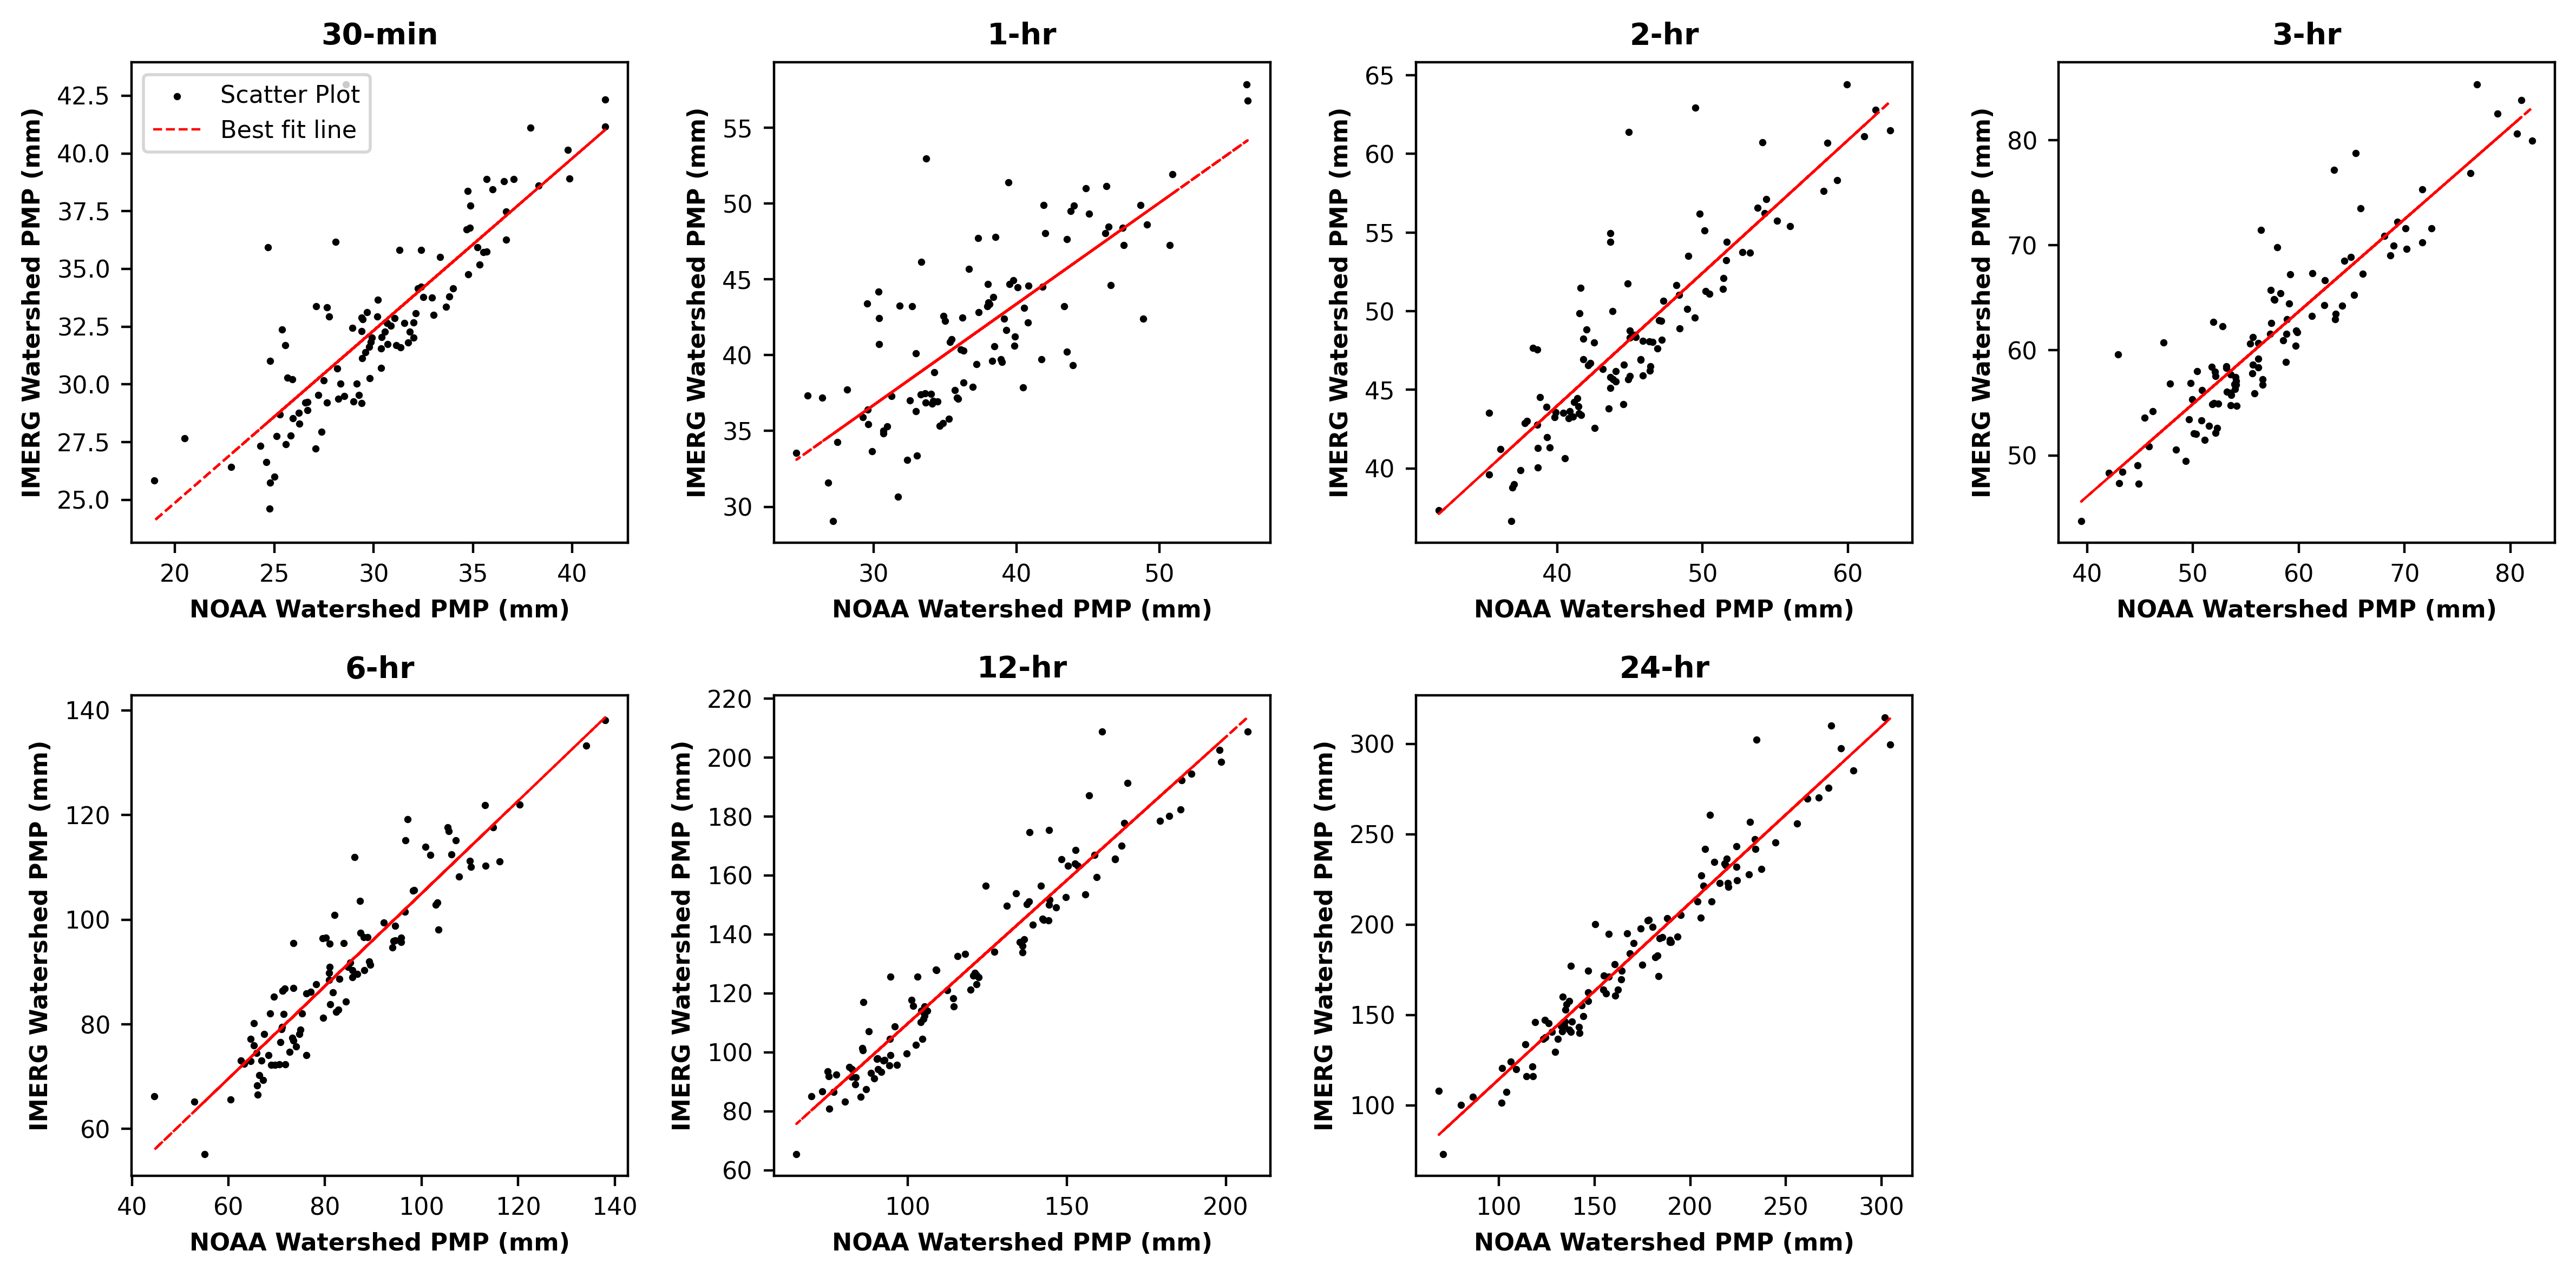

In [16]:
# Plot each output column against the unique "Year" values
plt.figure(figsize=(12, 6), dpi=400) 

plt.subplot(2, 4, 1)
plt.scatter(ST30m, IM30m, c="black", marker='o', s=2, label = "Scatter Plot")
a1, b1 = np.polyfit(ST30m, IM30m, 1)
plt.plot(ST30m, a1*ST30m+b1, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('30-min', fontweight='bold', fontsize=10)
plt.legend(loc=2, fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)



plt.subplot(2, 4, 2)
plt.scatter(ST1h, IM1h, c="black", marker='o', s=2, label = "Scatter Plot")
a2, b2 = np.polyfit(ST1h, IM1h, 1)
plt.plot(ST1h, a2*ST1h+b2, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('1-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)


plt.subplot(2, 4, 3)
plt.scatter(ST2h, IM2h, c="black", marker='o', s=2, label = "Scatter Plot")
a3, b3 = np.polyfit(ST2h, IM2h, 1)
plt.plot(ST2h, a3*ST2h+b3, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('2-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)


plt.subplot(2, 4, 4)
plt.scatter(ST3h, IM3h, c="black", marker='o', s=2, label = "Scatter Plot")
a4, b4 = np.polyfit(ST3h, IM3h, 1)
plt.plot(ST3h, a4*ST3h+b4, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('3-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)


plt.subplot(2, 4, 5)
plt.scatter(ST6h, IM6h, c="black", marker='o', s=2, label = "Scatter Plot")
a5, b5 = np.polyfit(ST6h, IM6h, 1)
plt.plot(ST6h, a5*ST6h+b5, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('6-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)


plt.subplot(2, 4, 6)
plt.scatter(ST12h, IM12h, c="black", marker='o', s=2, label = "Scatter Plot")
a6, b6 = np.polyfit(ST12h, IM12h, 1)
plt.plot(ST12h, a6*ST12h+b6, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('12-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)


plt.subplot(2, 4, 7)
a7, b7 = np.polyfit(ST24h, IM24h, 1)
plt.plot(ST24h, a7*ST24h+b7, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST24h, IM24h, c="black", marker='o', s=2, label = "Scatter Plot")
plt.xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=8)
plt.title('24-hr', fontweight='bold', fontsize=10)
# plt.legend(loc=1, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8)





plt.tight_layout()
# plt.savefig("maps/WatershedPMPBFL.png")
plt.show()


## **One to One Line**

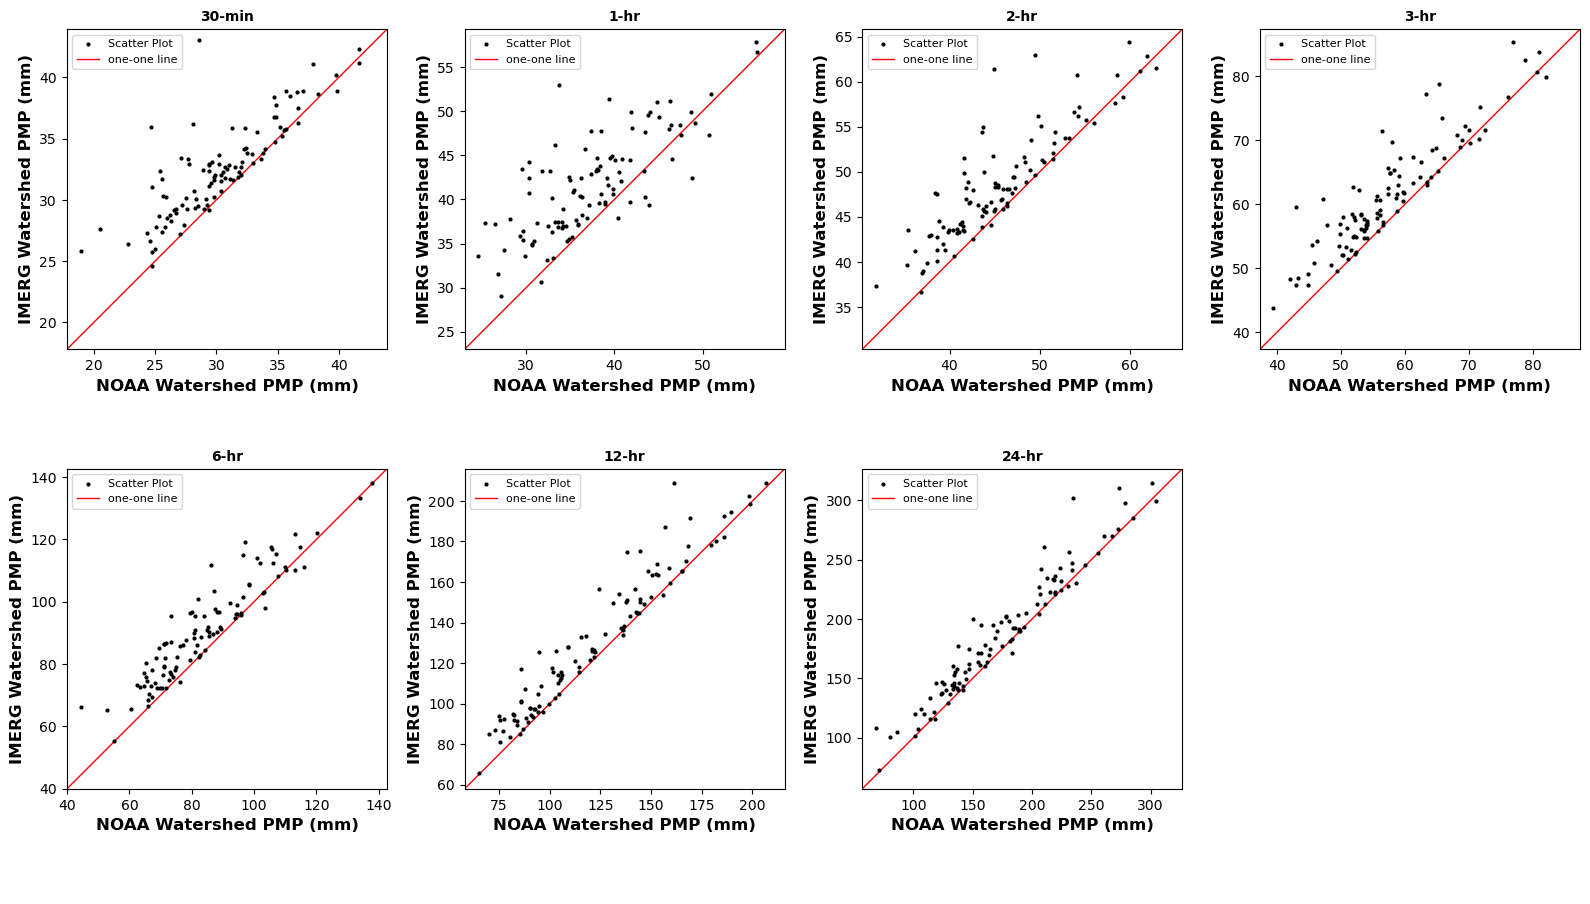

In [17]:
fig, ax = plt.subplots(2,4, figsize=(16,10))

ax = ax.flatten()
k=0
for ob, im, tt in zip(ober, img, tit):
    # set sub-plots adjustment parameters
    plt.subplots_adjust(hspace= -0.4, wspace=0.4)

    X1 = ob.values.reshape(-1, 1)
    Y1 = im.values.reshape(-1, 1)
    ax[k].scatter(X1, Y1, c="black", marker='o', s=4, label = "Scatter Plot")
    ax[k].set_xlabel('NOAA Watershed PMP (mm)', fontweight='bold', fontsize=12)
    ax[k].set_ylabel('IMERG Watershed PMP (mm)', fontweight='bold', fontsize=12)
    ax[k].set_title(tt, fontweight='bold', fontsize=10)

    lims = [

            np.min([ax[k].get_xlim(), ax[k].get_ylim()]),  # min of both axes

            np.max([ax[k].get_xlim(), ax[k].get_ylim()]),  # max of both axes

            ]

    ax[k].plot(lims, lims, 'r-', linewidth=1, zorder=0, label = "one-one line")

    ax[k].set(xlim=lims, ylim=lims)
    ax[k].legend(loc=2, fontsize=8)
    ax[k].set_aspect('equal')
    fig.tight_layout()
    ax[7].set_axis_off()
    k+=1

# plt.savefig("maps/WatershedPMP121L.png")

# **Statistics (CC, RB, NRMSE)**

In [8]:
def STATS(obs, pred):
    
    # Use hydroeval parameters
    pbias=he.evaluator(he.pbias, obs, pred)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, obs, pred)
    r_cor_val = np.round(r_cor[0], 3)
    # #calculate other metrics
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(obs, pred)
    
    # # Calculate Relative Bias
    RB1 = ((sum(pred)-sum(obs))/sum(obs))*100
    RB = np.round(RB1.values, 3)
    
    # Calculate the Root Mean Square Error (NRMSE) and Normalized RMSE
    rmse = np.sqrt(np.mean((obs - pred) ** 2))
    rmse_val = np.round(rmse.values, 3)
    
    obs_range = np.max(obs) - np.min(obs)
    NRMSE = rmse / obs_range
    NRMSE_val = np.round(NRMSE.values, 3)

    print("------------Start--------------")
    print("r_Cor     =", (r_cor_val))
    print('Relative Bias:', RB);
    # print("RMSE      =", rmse_val) 
    # print("Normalized RMSE      =", NRMSE_val) 
    print("----------- END---------------")
    


ober = [ST30m, ST1h, ST2h, ST3h, ST6h, ST12h, ST24h]  # NOAA Watershed PMP
img = [IM30m, IM1h, IM2h, IM3h, IM6h, IM12h, IM24h]  # IMERG Interpolated PMP
tit = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr']

for obr, im, tt in zip(ober, img, tit):
    ob = obr;
    pred = im;
    output = STATS(ob, pred)
    print(output) 

------------Start--------------
r_Cor     = 0.839
Relative Bias: 7.435
----------- END---------------
None
------------Start--------------
r_Cor     = 0.763
Relative Bias: 11.357
----------- END---------------
None
------------Start--------------
r_Cor     = 0.878
Relative Bias: 6.933
----------- END---------------
None
------------Start--------------
r_Cor     = 0.914
Relative Bias: 6.989
----------- END---------------
None
------------Start--------------
r_Cor     = 0.931
Relative Bias: 8.2
----------- END---------------
None
------------Start--------------
r_Cor     = 0.963
Relative Bias: 7.567
----------- END---------------
None
------------Start--------------
r_Cor     = 0.969
Relative Bias: 7.254
----------- END---------------
None


# **Method Comparison**

In [12]:
dfa = pd.read_csv('./WshedPMPStats.csv')
# print(dfa)

In [13]:
xar1 = dfa.to_xarray()

Du = xar1['Durations'];

pt_avg = xar1['pt_avg']; pt_cum = xar1['pt_cum']; pt_stdv = xar1['pt_stdv']; pt_cv = xar1['pt_cv']; 
wp_avg = xar1['wp_avg']; wp_cum = xar1['wp_cum']; wp_stdv = xar1['wp_stdv']; wp_cv = xar1['wp_cv']; 
wi_avg = xar1['wi_avg']; wi_cum = xar1['wi_cum']; wi_stdv = xar1['wi_stdv']; wi_cv = xar1['wi_cv']; 
wn_avg = xar1['wn_avg']; wn_cum = xar1['wn_cum']; wn_stdv = xar1['wn_stdv']; wn_cv = xar1['wn_cv'];
st_avg = xar1['st_avg']; st_cum = xar1['st_cum']; st_stdv = xar1['st_stdv']; st_cv = xar1['st_cv'];

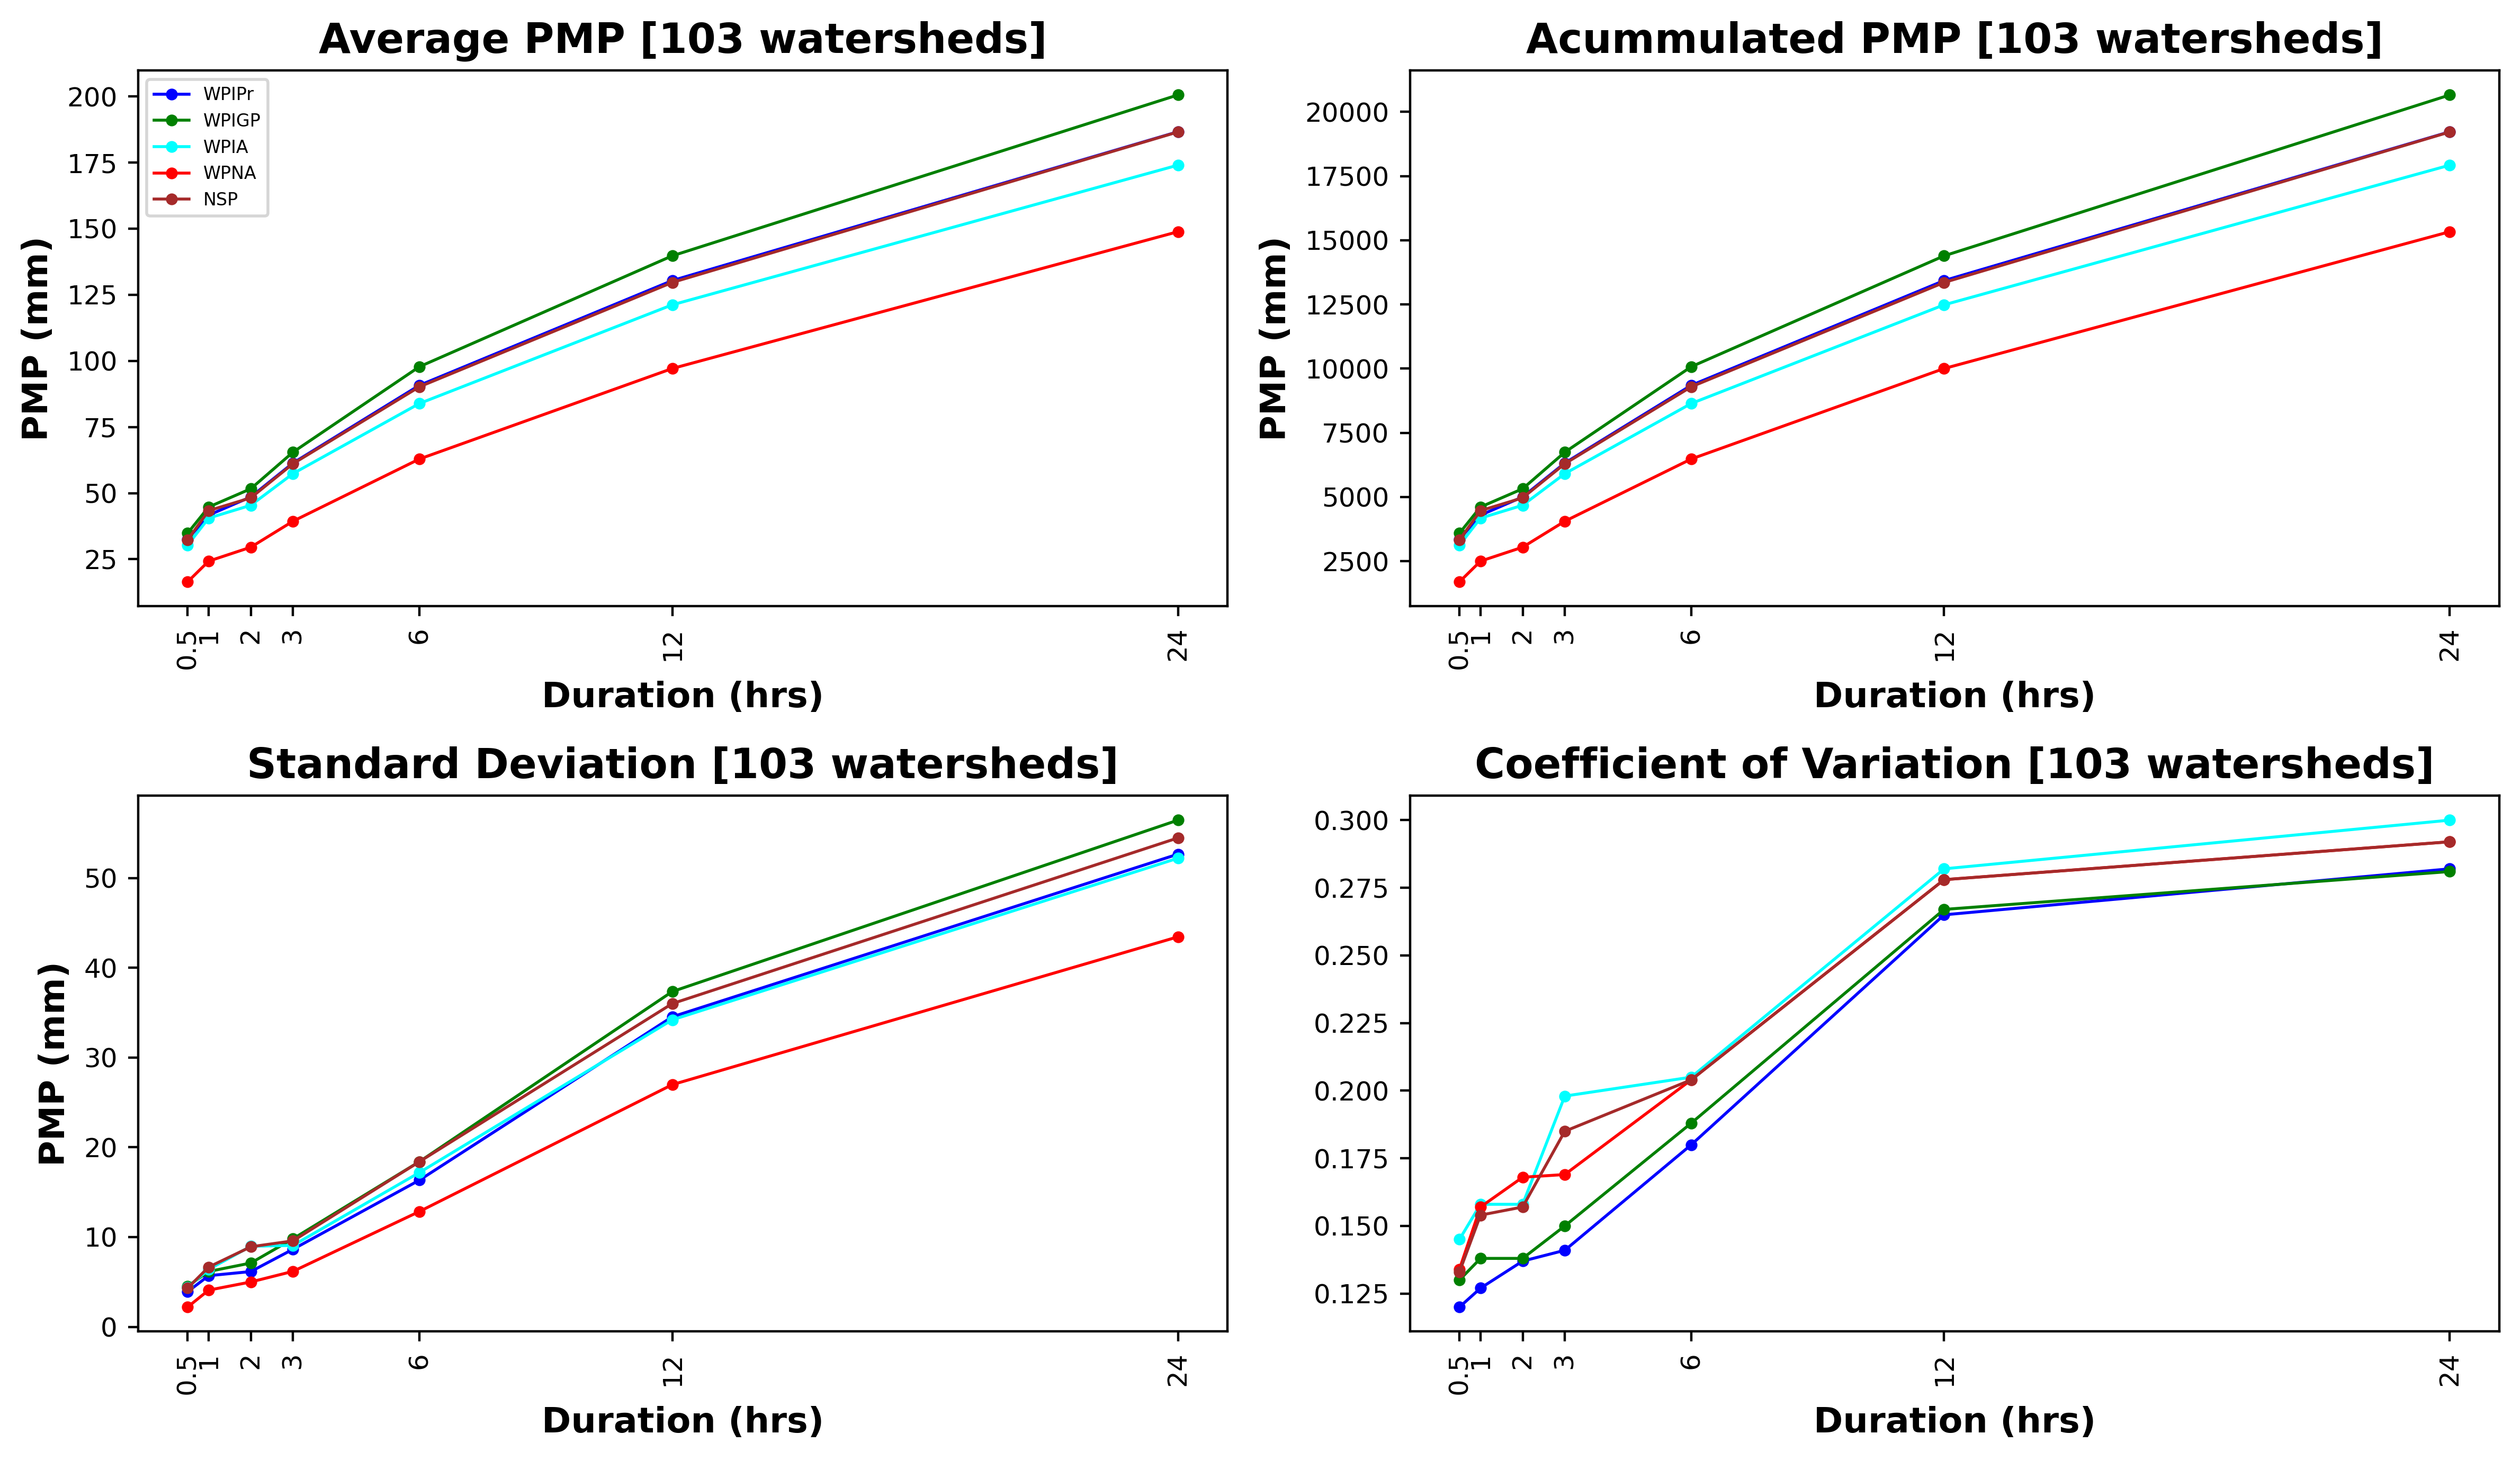

In [18]:
plt.figure(figsize=(12, 7), dpi=400)
labels = ['0.5', '1', '2', '3', '6', '12', '24']

plt.subplot(2,2,1)
plt.plot(Du, pt_avg, color='blue', marker = '.', markersize=6, linewidth=1, label = "WPIPr")
plt.plot(Du, wp_avg, color='green', marker = '.', markersize=6, linewidth=1, label = "WPIGP")
plt.plot(Du, wi_avg, color='cyan', marker = '.', markersize=6, linewidth=1, label = "WPIA")
plt.plot(Du, wn_avg, color='red', marker = '.', markersize=6, linewidth=1, label = "WPNA")
plt.plot(Du, st_avg, color='brown', marker = '.', markersize=6, linewidth=1, label = "NSP")
plt.xlabel('Duration (hrs)',  fontweight='bold', fontsize=12)
plt.ylabel('PMP (mm)', fontweight='bold', fontsize=12)
plt.title('Average PMP [103 watersheds]', fontweight='bold', fontsize=14)
plt.legend(loc=2, fontsize=6)
plt.xticks(Du, labels, rotation=90, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=9)

plt.subplot(2,2,2)
plt.plot(Du, pt_cum, color='blue', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Precipitation")
plt.plot(Du, wp_cum, color='green', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Gridded PMP")
plt.plot(Du, wi_cum, color='cyan', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG ARF")
plt.plot(Du, wn_cum, color='red', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from NOAA ARF")
plt.plot(Du, st_cum, color='brown', marker = '.', markersize=6, linewidth=1, label = "NOAA Station PMP")
plt.xlabel('Duration (hrs)',  fontweight='bold', fontsize=12)
plt.ylabel('PMP (mm)', fontweight='bold', fontsize=12)
plt.title('Acummulated PMP [103 watersheds]', fontweight='bold', fontsize=14)
# plt.legend(loc=2, fontsize=8)
plt.xticks(Du, labels, rotation=90, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=9)

plt.subplot(2,2,3)
plt.plot(Du, pt_stdv, color='blue', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Precipitation")
plt.plot(Du, wp_stdv, color='green', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Gridded PMP")
plt.plot(Du, wi_stdv, color='cyan', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG ARF")
plt.plot(Du, wn_stdv, color='red', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from NOAA ARF")
plt.plot(Du, st_stdv, color='brown', marker = '.', markersize=6, linewidth=1, label = "NOAA Station PMP")
plt.xlabel('Duration (hrs)',  fontweight='bold', fontsize=12)
plt.ylabel('PMP (mm)', fontweight='bold', fontsize=12)
plt.title('Standard Deviation [103 watersheds]', fontweight='bold', fontsize=14)
# plt.legend(loc=2, fontsize=8)
plt.xticks(Du, labels, rotation=90, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=9)


plt.subplot(2,2,4)
plt.plot(Du, pt_cv, color='blue', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Precipitation")
plt.plot(Du, wp_cv, color='green', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG Gridded PMP")
plt.plot(Du, wi_cv, color='cyan', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from IMERG ARF")
plt.plot(Du, wn_cv, color='red', marker = '.', markersize=6, linewidth=1, label = "Watershed PMP from NOAA ARF")
plt.plot(Du, st_cv, color='brown', marker = '.', markersize=6, linewidth=1, label = "NOAA Station PMP")
plt.xlabel('Duration (hrs)',  fontweight='bold', fontsize=12)
# plt.ylabel('PMP (mm)', fontweight='bold', fontsize=12)
plt.title('Coefficient of Variation [103 watersheds]', fontweight='bold', fontsize=14)
# plt.legend(loc=2, fontsize=8)
plt.xticks(Du, labels, rotation=90, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=9)


plt.tight_layout()
# plt.savefig("maps/WatershedPMPStats.png")
plt.show()